In [271]:
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np

import copy 

from vmp import VMP

### 1. Via-points Movement Primitives (VMP)

In [272]:
q0 = torch.tensor([-0.5, -0.5])
q1 = torch.tensor([0.5, 0.5])
b = 10
h_mul = 1
dim = 2

In [273]:
init_w = 3*torch.cat([
    torch.sin(torch.linspace(0, 1, b)).view(1, -1, 1),
    torch.cos(torch.linspace(0, 1, b)).view(1, -1, 1)
], dim=-1)

#### 1.1. Perturb with Euclidean metric

In [281]:
ws = [init_w]
dw = 5
for i in range(2):
    for j in range(10):
        temp = copy.deepcopy(init_w)
        temp[0, j, i] += dw
        ws.append(temp)
ws = torch.cat(ws, dim=0)

In [282]:
model_vmp = VMP(
    b=b,
    h_mul=h_mul,
    dim=dim,
    via_points=[q0, q1],
    num_curves=21
    )

model_vmp.set_w(ws)
t = torch.linspace(0, 1, 500).view(1, -1, 1)
trajs = model_vmp(t).detach().cpu().numpy()

In [283]:
diff_values = np.linalg.norm(trajs[0:1] - trajs, axis=(-1, -2))
sort_idx = diff_values.argsort()
trajs = trajs[sort_idx]
diff_values[sort_idx]

array([0.       , 0.8781602, 0.8781602, 0.8781602, 0.8781602, 2.4888382,
       2.4888384, 2.4888384, 2.4888384, 4.0602465, 4.0602465, 4.060247 ,
       4.060247 , 5.172494 , 5.172494 , 5.172494 , 5.172494 , 5.736465 ,
       5.736465 , 5.736466 , 5.736466 ], dtype=float32)

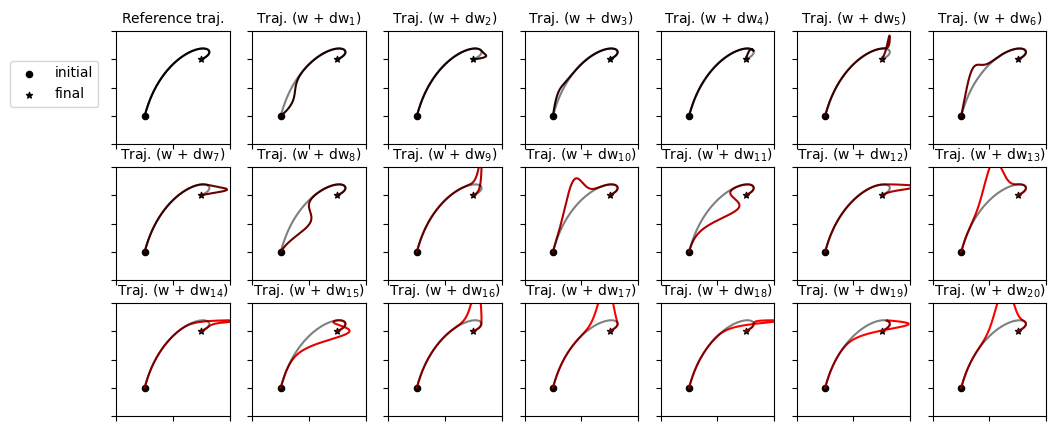

In [284]:
fig, ax = plt.subplots(3, 7, figsize=(12, 5))

n = 0
for i in range(3):
    for j in range(7):
        if i == 0 and j == 0:
            ax[i, j].set_title('Reference traj.', fontsize=10)
        else:
            ax[i, j].set_title(f'Traj. (w + dw$_{{{n}}}$)', fontsize=10)
        diff_norm = diff_values[sort_idx][n]
        ax[i, j].plot(trajs[n, :, 0], trajs[n, :, 1], c=[diff_norm.item()/diff_values[sort_idx].max(), 0, 0])
        ax[i, j].plot(trajs[0, :, 0], trajs[0, :, 1], c='k', alpha=0.5)
        ax[i, j].scatter(trajs[n, 0, 0], trajs[n, 0, 1], c='k', marker='o', s=20, label='initial')
        ax[i, j].scatter(trajs[n, -1, 0], trajs[n, -1, 1], c='k', marker='*', s=20, label='final')
        ax[i, j].set_xlim(-1, 1)
        ax[i, j].set_ylim(-1, 1)
        ax[i, j].set_aspect('equal')
        ax[i, j].tick_params(axis='both', which='both', labelbottom=False, labelleft=False)
        n += 1  
ax[0, 0].legend(loc='upper left', bbox_to_anchor=(-1, 0.8))
plt.show()

#### 1.2. Perturb with Riemannian metric

In [286]:
U, S, V = torch.svd(model_vmp.G)
G_invsqrt = (U@torch.diag_embed(S**(-1/2))@V.permute(0, 2, 1))
G_invsqrt = G_invsqrt/torch.trace(G_invsqrt[0]) * b

ws = [init_w]
dw = 5
for i in range(2):
    for j in range(10):
        temp = copy.deepcopy(init_w)
        temp[0, :, i] += dw * G_invsqrt[0, :, j]
        ws.append(temp)
ws = torch.cat(ws, dim=0)

model_vmp = VMP(
    b=b,
    h_mul=h_mul,
    dim=dim,
    via_points=[q0, q1],
    num_curves=21
    )

model_vmp.set_w(ws)
t = torch.linspace(0, 1, 500).view(1, -1, 1)
trajs = model_vmp(t).detach().cpu().numpy()

diff_values = np.linalg.norm(trajs[0:1] - trajs, axis=(-1, -2))
sort_idx = diff_values.argsort()
trajs = trajs[sort_idx]
diff_values[sort_idx]

array([0.       , 1.230322 , 1.2303224, 1.2303226, 1.2303228, 1.2303236,
       1.2303238, 1.2303238, 1.230324 , 1.2303255, 1.2303255, 1.2303265,
       1.2303267, 1.2303272, 1.2303272, 1.2303272, 1.2303275, 1.2303288,
       1.2303288, 1.230331 , 1.230331 ], dtype=float32)

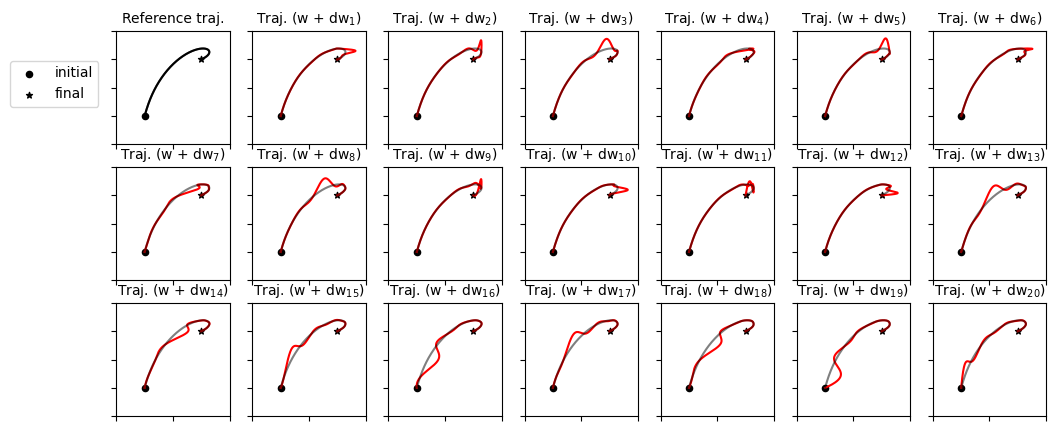

In [287]:
fig, ax = plt.subplots(3, 7, figsize=(12, 5))

n = 0
for i in range(3):
    for j in range(7):
        if i == 0 and j == 0:
            ax[i, j].set_title('Reference traj.', fontsize=10)
        else:
            ax[i, j].set_title(f'Traj. (w + dw$_{{{n}}}$)', fontsize=10)
        diff_norm = diff_values[sort_idx][n]
        ax[i, j].plot(trajs[n, :, 0], trajs[n, :, 1], c=[diff_norm.item()/diff_values[sort_idx].max(), 0, 0])
        ax[i, j].plot(trajs[0, :, 0], trajs[0, :, 1], c='k', alpha=0.5)
        ax[i, j].scatter(trajs[n, 0, 0], trajs[n, 0, 1], c='k', marker='o', s=20, label='initial')
        ax[i, j].scatter(trajs[n, -1, 0], trajs[n, -1, 1], c='k', marker='*', s=20, label='final')
        ax[i, j].set_xlim(-1, 1)
        ax[i, j].set_ylim(-1, 1)
        ax[i, j].set_aspect('equal')
        ax[i, j].tick_params(axis='both', which='both', labelbottom=False, labelleft=False)
        n += 1  
ax[0, 0].legend(loc='upper left', bbox_to_anchor=(-1, 0.8))
plt.show()